In [24]:
import numpy as np
from collections import Counter
prefex= 'research/file_system_trace/FIU/storage_energy/'
file1 = 'online.cs.fiu.edu-110108-113008.1.blkparse'
file2 = 'webmail.cs.fiu.edu-110108-113008.1.blkparse'
filemix = 'webmail+online.cs.fiu.edu-110108-113008.1.blkparse'

small_trace = np.loadtxt(file1,usecols=(0,1,3))

pid = Counter(small_trace[:,1]).most_common(10)
p = (np.array(pid))[:,0]
c=0
labels = {}
for i in p:
    labels[i]=c
    c +=1
print(labels)
fo = open('online.csv','w')

for i in small_trace:
    c=0
    signal = np.zeros((1,len(labels)),dtype=np.uint32)
    if i[1] in p:
        ts = i[0]
        c = labels[i[1]]
        signal[0,c]=i[2]
        fo.write(','.join(map(str,signal[0]))+',-,'+str(ts)+'\n')

In [46]:
small_trace = np.loadtxt(filemix,usecols=(0,1,3))
with open('web_online.csv','w') as fo:
    for i in small_trace:
        c=0
        signal = np.zeros((1,len(labels)),dtype=np.uint32)
        if i[1] in p:
            ts = i[0]
            c = labels[i[1]]
            signal[0,c]=i[2]
            fo.write(','.join(map(str,signal[0]))+',-,'+str(ts)+'\n')

(485014, 5)
(201876, 5)
time.struct_time(tm_year=2018, tm_mon=10, tm_mday=24, tm_hour=23, tm_min=49, tm_sec=14, tm_wday=2, tm_yday=297, tm_isdst=1) normalized
(201876, 5)
(201876, 5)
time.struct_time(tm_year=2018, tm_mon=10, tm_mday=24, tm_hour=23, tm_min=49, tm_sec=15, tm_wday=2, tm_yday=297, tm_isdst=1) ICA calculated
time.struct_time(tm_year=2018, tm_mon=10, tm_mday=24, tm_hour=23, tm_min=49, tm_sec=18, tm_wday=2, tm_yday=297, tm_isdst=1) PCA calculated
time.struct_time(tm_year=2018, tm_mon=10, tm_mday=24, tm_hour=23, tm_min=49, tm_sec=21, tm_wday=2, tm_yday=297, tm_isdst=1) Amuse calculated
time.struct_time(tm_year=2018, tm_mon=10, tm_mday=24, tm_hour=23, tm_min=49, tm_sec=25, tm_wday=2, tm_yday=297, tm_isdst=1) jade calculated
time.struct_time(tm_year=2018, tm_mon=10, tm_mday=24, tm_hour=23, tm_min=49, tm_sec=28, tm_wday=2, tm_yday=297, tm_isdst=1) jade calculated


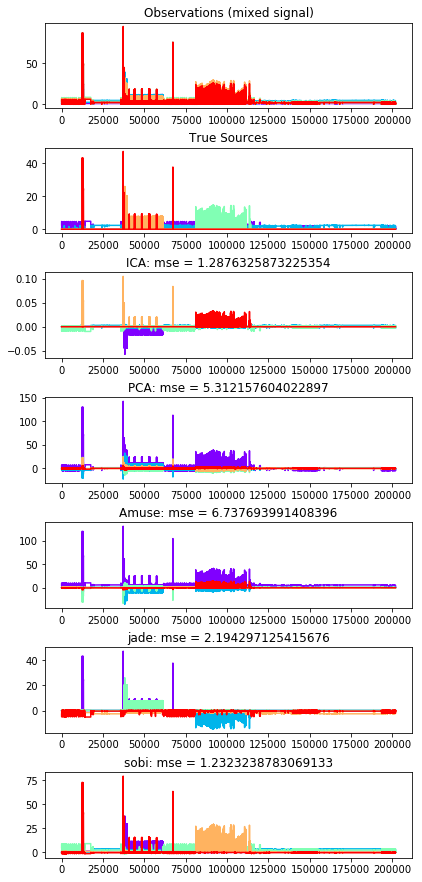

In [91]:
from sklearn.metrics import mean_squared_error
import copy
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from sklearn.decomposition import FastICA, PCA
from sklearn import preprocessing
import time
import sys
from sklearn.metrics import mean_squared_error
from sklearn.metrics import explained_variance_score
from amuse import amuse
from jade import jadeR
from shogun import SOBI,RealFeatures
from itertools import permutations

def get_error(ground_truth,signalmat):
    # we want to try every possible signal order
    g=ground_truth.T
    s=signalmat.T
    l = len(s)    
    best_err = 10000
    p = list(permutations(range(l),l))
    
    for i in p:
        err=mean_squared_error(g,s[i,:])
        if err < best_err:
             best_err = err
    return best_err

def get_ica(fn = 'top10_pids_signal_fiu.csv'):
    
    signal=np.loadtxt(fn,delimiter=',',usecols=(1,2,3,4,5))
    print (signal.shape)
    signal = signal[~(signal==0).all(1)]
    #print('independence:',chi2_contingency(signal))
    print (signal.shape)
    signal /= signal.std(axis=0) #normalize
    print (time.localtime(),'normalized')
    print (signal.shape)
    nc = len(signal[0])
   
 
    A = np.array([[0.2, 0.4, 0.5, 1.5, 1], [0.5, 2.0, 1.0,1.5,.75], [1.75,1.5, 1.0,.5,2.0],[1.5,.75,2,1.25,1],[1.25,1,1.75,.5,2]])  # Mixing matrix
    #A = np.array([[1, 1, 1, 1, 1], [0.5, 2.0, 1.0,1.5,.75], [1.75,1.5, 1.0,.5,2.0],[1.5,.75,2,1.25,1],[1.25,1,1.75,.5,2]])
    
    #A = np.array([[0.2, 0.4, 0.5, 0.35, 0.25], [0.3, 0.2, 0.1,0.15,0.05], [0.1,0.5, 0.25,0.4,1.0],[0.15,0.05,0.2,0.25,0.1],[0.25,0.1,0.3,0.5,0.2]])
    #A = np.array([[0.2, 0.4, 0.5, 0.35, 0.25], [0.3, 0.2, 0.1,0.75,0.05], [0.1,0.5, 0.25,0.4,1.0],[0.15,0.05,0.2,0.25,0.1],[0.25,0.1,0.3,0.5,0.2]])
    #A = np.array([[1, 1, 1], [0.5, 2, 1.0], [1.75,1.5, 1.0]])  # Mixing matrix
    signal_ = np.dot(signal,A.T)
  # TODO: Show signals are statistically independent : some variant of Chi^2 test?  ok
  # TODO: Show signals are not Gaussian (should be easy... )
  # TODO: Justify mixing matrix choice (must be full rank)
  # (http://www.tqmp.org/RegularArticles/vol06-1/p031/p031.pdf)
  # FIXME: Does Factor analsis not apply to non-Gaussians?
  # TODO: Attempt on "mixed" completely unlabeled data.
  # TODO: Attempt on more features
    print (signal_.shape)
    #print('correlation:',np.corrcoef(signal.T))
  # Compute ICA
    ica = FastICA(n_components=nc)
    S_ = ica.fit_transform(signal_)  # Reconstruct signals
    A_ = ica.mixing_  # Get estimated mixing matrix
    print (time.localtime(),'ICA calculated')
    ica_err=get_error(signal,S_)#,np.mean(signal-abs(S_))

    pca = PCA(n_components=nc)
    H = pca.fit_transform(signal_)  # Reconstruct signals based on orthogonal components
    print (time.localtime(),'PCA calculated')
    pca_err=get_error(signal,H)

    #estimated sources
    amuse_me = amuse(signal_.T, nc, 1)
    s_hat = (amuse_me.sources).T

    print (time.localtime(),'Amuse calculated')
    amuse_err=get_error(signal,s_hat)
    
    #estimated sources
    jade=np.asarray(jadeR(signal_.T,verbose=False))
    J=np.dot(jade,signal_.T)

    print (time.localtime(),'jade calculated')
    jade_err=get_error(signal,J.T)
    
    #estimated sources
    sep = SOBI()
    signal_o = RealFeatures((signal_.T).astype(np.float64))             
    signals = sep.apply(signal_o)

    So = signals.get_feature_matrix()

    print (time.localtime(),'jade calculated')
    sobi_err=get_error(signal,So.T)
    
    fig=plt.figure()

    models = [signal_,signal, S_,H,s_hat,J.T,So.T]
    names = ['Observations (mixed signal)',
           'True Sources',
           'ICA: mse = '+str(ica_err),
           'PCA: mse = '+str(pca_err),
           'Amuse: mse = '+str(amuse_err),
            'jade: mse = '+str(jade_err),
            'sobi: mse = '+str(sobi_err)]
    colors=cm.rainbow(np.linspace(0,1,nc))

    for ii, (model, name) in enumerate(zip(models, names), 1):
        plt.subplot(7, 1, ii)
        plt.title(name)
        for sig, color in zip(model.T, colors):
            plt.plot(sig, color=color)

    plt.subplots_adjust(0.09, 0.04, 0.94, 2.94, 0.26, 0.46)
    #fig.tight_layout() # show no overlap graph
    plt.show()
if __name__=='__main__':
  #get_signal_and_write_to_file(binsize=10000)

    #get_ica(fn='new_online.csv')
    
    get_ica(fn='web_online.csv')    
